#Trabalho Final da Disciplina Agrupamento de Dados

## 1 - Importando as bibliotecas necessárias para rodar o projeto

In [1]:
import pandas as pd
import hdbscan
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score, fowlkes_mallows_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean, pdist


## 2 - Carregando as bases de dados

#### Wine Quality Dataset (Repositório UCI)
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

In [2]:
# Carregar dados
wine_data = pd.read_csv('../datasets/winequality-red.csv', delimiter=';')

# Remover valores ausentes (se houver)
wine_data = wine_data.dropna()

# Separar features e rótulo
wine_features = wine_data.drop('quality', axis=1)

# Normalizar os dados
scaler = StandardScaler()
wine_data_scaled = scaler.fit_transform(wine_features)


#### Breast Cancer Wisconsin (Repositório UCI)
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

In [3]:
# Carregar dados
breast_cancer_data = pd.read_csv('../datasets/wdbc.data', header=None)

# Renomear coluna
breast_cancer_data.columns = ['ID', 'Diagnosis'] + [f'feature_{i}' for i in range(1, 31)]

# Remover colunas desnecessárias
breast_cancer_data = breast_cancer_data.drop(['ID', 'Diagnosis'], axis=1)

# Remover valores ausentes (se houver)
breast_cancer_data = breast_cancer_data.dropna()

# Normalizar os dados
scaler = StandardScaler()
breast_cancer_data_scaled = scaler.fit_transform(breast_cancer_data)


#### Abalone Dataset (Repositório UCI)
https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data

In [4]:
# Carregar dados
abalone_data = pd.read_csv('../datasets/abalone.data', header=None)

# Renomear colunas
abalone_data.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# Converter variáveis categóricas
abalone_data['Sex'] = abalone_data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# Remover valores ausentes (se houver)
abalone_data = abalone_data.dropna()

# Separar features e rótulo
abalone_features = abalone_data.drop('Rings', axis=1)
abalone_labels = abalone_data['Rings']

# Normalizar os dados
scaler = StandardScaler()
abalone_data_scaled = scaler.fit_transform(abalone_features)


#### Ecoli Dataset (Repositório UCI)
https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data

In [5]:
# Carregar dados
ecoli_data = pd.read_csv('../datasets/ecoli.data', delim_whitespace=True, header=None)

# Renomear colunas
ecoli_data.columns = ['Sequence Name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'Class']

ecoli_data = ecoli_data.drop(['Sequence Name', 'Class'], axis=1)

# Remover valores ausentes (se houver)
ecoli_data = ecoli_data.dropna()

# Normalizar os dados
scaler = StandardScaler()
ecoli_data_scaled = scaler.fit_transform(ecoli_data)


/tmp/ipykernel_448805/380386819.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ecoli_data = pd.read_csv('../datasets/ecoli.data', delim_whitespace=True, header=None)


## Implementando os algoritmos

#### K-means

In [6]:
def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    return clusters, kmeans.labels_

#### DBSCAN

In [7]:
def dbscan_clustering(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    return clusters, dbscan.labels_

#### HDBSCAN

In [8]:
def hdbscan_clustering(data, min_cluster_size, min_samples=5):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusters = clusterer.fit_predict(data)
    return clusters, clusterer.labels_

## Implementando as Medidas de Comparação

#### Coeficiente de Silhueta

In [9]:
def safe_calculate_silhouette_score(data, labels):
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        return silhouette_score(data, labels)
    else:
        return 0

#### Adjusted Rand Index (ARI)

In [10]:
def calculate_ari(clusters_true, clusters_pred):
    return adjusted_rand_score(clusters_true, clusters_pred)

### Rand Score

In [11]:
def calculate_rand_score(clusters_true, clusters_pred):
    return rand_score(clusters_true, clusters_pred)

### Fowlkes-Mallows Score

In [12]:
def calculate_fowlkes_mallows_score(clusters_true, clusters_pred):
    return fowlkes_mallows_score(clusters_true, clusters_pred)


### Índice de Dunn

In [13]:
def calculate_dunn_index(data, labels):
    unique_labels = np.unique(labels)
    clusters = [data[labels == label] for label in unique_labels if label != -1]

    if len(clusters) < 2:
        return 0

    diameters = []
    for cluster in clusters:
        if len(cluster) > 1:
            diameters.append(np.max(pdist(cluster)))
        else:
            diameters.append(0)

    min_intercluster_distance = np.inf
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            if len(clusters[i]) > 0 and len(clusters[j]) > 0:
                for point_i in clusters[i]:
                    for point_j in clusters[j]:
                        distance = euclidean(point_i, point_j)
                        if distance < min_intercluster_distance:
                            min_intercluster_distance = distance

    if min_intercluster_distance == np.inf:
        return 0

    dunn_index = min_intercluster_distance / np.max(diameters)
    return dunn_index


### Preparando base de dados

In [14]:
datasets = {
    'Breast Cancer': (breast_cancer_data_scaled, breast_cancer_data['feature_1']),
    'Wine Quality': (wine_data_scaled, wine_data['quality']),
    'Abalone': (abalone_data_scaled, abalone_data['Rings']),
    'Ecoli': (ecoli_data_scaled, ecoli_data['alm1'])
}

kmeans_clusters = {
    'Breast Cancer': 2,
    'Wine Quality': 6,
    'Abalone': 3,
    'Ecoli': 8
}
results = []

## Executando as clusterizações nas bases de dados

In [15]:
for dataset_name, (data_scaled, true_labels) in datasets.items():
  
    # K-means

    clusters_kmeans, labels_kmeans = kmeans_clustering(data_scaled, n_clusters=kmeans_clusters[dataset_name])
    silhouette_kmeans = safe_calculate_silhouette_score(data_scaled, clusters_kmeans)
    ari_kmeans = calculate_ari(true_labels, labels_kmeans)
    rand_kmeans = calculate_rand_score(true_labels, labels_kmeans)
    fowlkes_mallows_kmeans = calculate_fowlkes_mallows_score(true_labels, labels_kmeans)
    dunn_kmeans = calculate_dunn_index(data_scaled, labels_kmeans)

    results.append({'Dataset': dataset_name, 'Algorithm': 'K-means', 'Silhouette Score': silhouette_kmeans, 
                    'ARI': ari_kmeans, 'Rand Score': rand_kmeans, 'Fowlkes-Mallows': fowlkes_mallows_kmeans, 'Dunn Index': dunn_kmeans})

    # DBSCAN

    eps_dbscan = 5.0 
    clusters_dbscan, labels_dbscan = dbscan_clustering(data_scaled, eps=eps_dbscan, min_samples=5)
    silhouette_dbscan = safe_calculate_silhouette_score(data_scaled, clusters_dbscan)
    ari_dbscan = calculate_ari(true_labels, labels_dbscan)
    rand_dbscan = calculate_rand_score(true_labels, labels_dbscan)
    fowlkes_mallows_dbscan = calculate_fowlkes_mallows_score(true_labels, labels_dbscan)
    dunn_dbscan = calculate_dunn_index(data_scaled, labels_dbscan)
    
    results.append({'Dataset': dataset_name, 'Algorithm': 'DBSCAN', 'Silhouette Score': silhouette_dbscan, 
                    'ARI': ari_dbscan, 'Rand Score': rand_dbscan, 'Fowlkes-Mallows': fowlkes_mallows_dbscan, 'Dunn Index': dunn_dbscan})

    # HDBSCAN

    min_cluster_size_hdbscan = 10
    clusters_hdbscan, labels_hdbscan = hdbscan_clustering(data_scaled, min_cluster_size=min_cluster_size_hdbscan)
    silhouette_hdbscan = safe_calculate_silhouette_score(data_scaled, clusters_hdbscan)
    ari_hdbscan = calculate_ari(true_labels, labels_hdbscan)
    rand_hdbscan = calculate_rand_score(true_labels, labels_hdbscan)
    fowlkes_mallows_hdbscan = calculate_fowlkes_mallows_score(true_labels, labels_hdbscan)
    dunn_hdbscan = calculate_dunn_index(data_scaled, labels_hdbscan)
    
    results.append({'Dataset': dataset_name, 'Algorithm': 'HDBSCAN', 'Silhouette Score': silhouette_hdbscan, 
                    'ARI': ari_hdbscan, 'Rand Score': rand_hdbscan, 'Fowlkes-Mallows': fowlkes_mallows_hdbscan, 'Dunn Index': dunn_hdbscan})


/home/pericles/Projects/mestrado/projeto-agrupamento/comparative_study_clustering_techniques/.venv/lib64/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/pericles/Projects/mestrado/projeto-agrupamento/comparative_study_clustering_techniques/.venv/lib64/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/pericles/Projects/mestrado/projeto-agrupamento/comparative_study_clustering_techniques/.venv/lib64/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning

/home/pericles/Projects/mestrado/projeto-agrupamento/comparative_study_clustering_techniques/.venv/lib64/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/pericles/Projects/mestrado/projeto-agrupamento/comparative_study_clustering_techniques/.venv/lib64/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/pericles/Projects/mestrado/projeto-agrupamento/comparative_study_clustering_techniques/.venv/lib64/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning

### Plotagem dos Resultados Obtidos

/tmp/ipykernel_444712/3509527821.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Silhouette Score', data=df_dataset, ax=axes[0, i], palette=palette)
/tmp/ipykernel_444712/3509527821.py:10: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x='Algorithm', y='Silhouette Score', data=df_dataset, ax=axes[0, i], palette=palette)
/tmp/ipykernel_444712/3509527821.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Rand Score', data=df_dataset, ax=axes[1, i], palette=palette)
/tmp/ipykernel_444712/3509527821.py:18: UserWarning: The palette list has more values (8) than needed (3), which may not be in

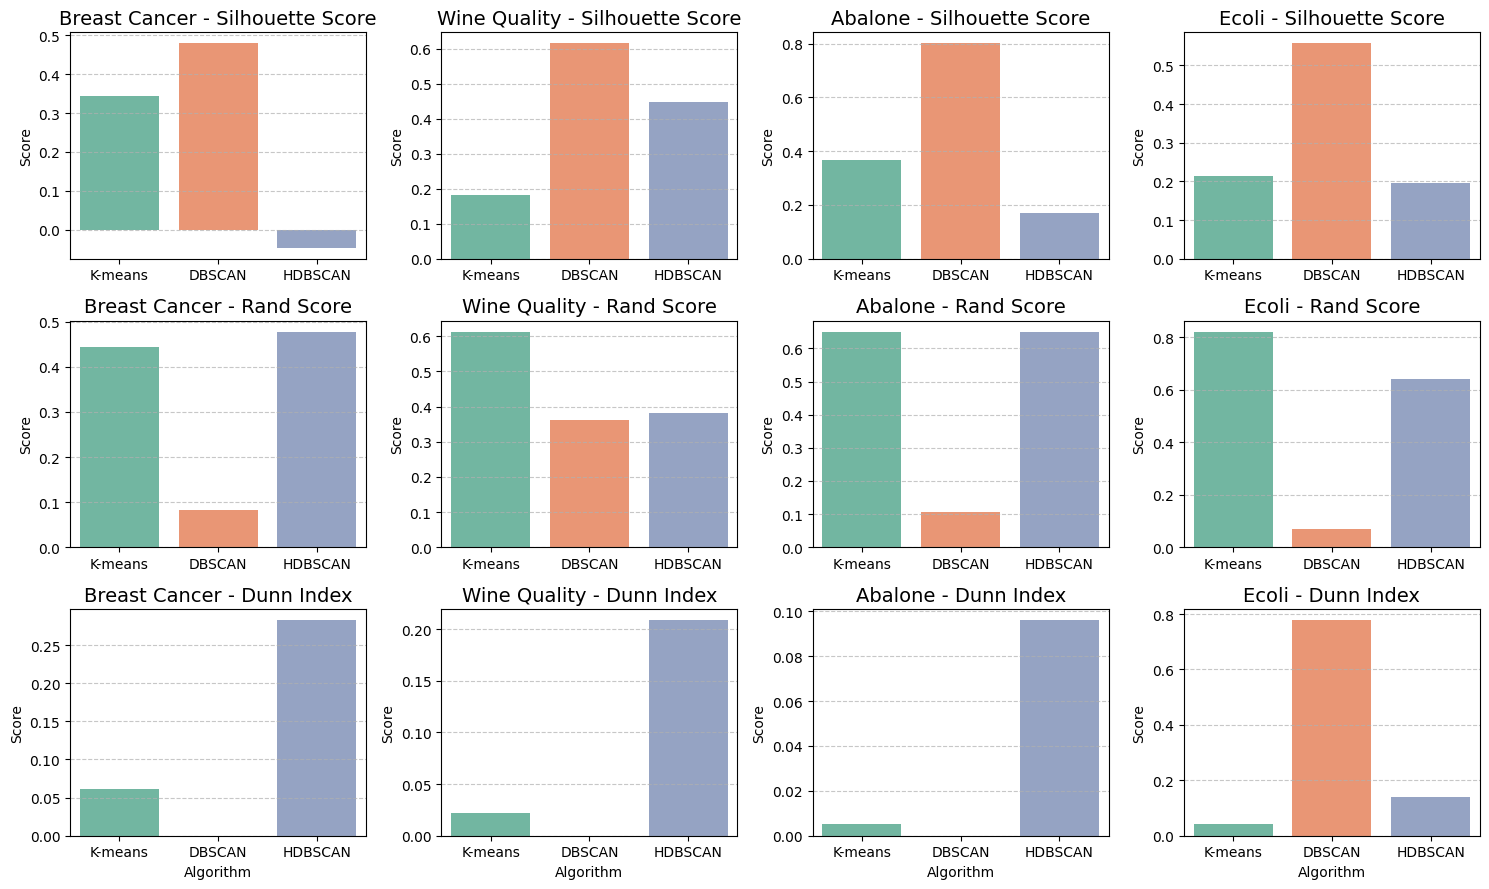

In [16]:
df_results = pd.DataFrame(results)

fig, axes = plt.subplots(nrows=3, ncols=len(datasets), figsize=(15, 9))
palette = sns.color_palette('Set2')

for i, dataset_name in enumerate(datasets.keys()):
    df_dataset = df_results[df_results['Dataset'] == dataset_name]
    
    # Silhouette
    sns.barplot(x='Algorithm', y='Silhouette Score', data=df_dataset, ax=axes[0, i], palette=palette)
    axes[0, i].set_title(f'{dataset_name} - Silhouette Score', fontsize=14)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('Score')
    axes[0, i].grid(True, axis='y', linestyle='--', alpha=0.7)


    # Rand Score
    sns.barplot(x='Algorithm', y='Rand Score', data=df_dataset, ax=axes[1, i], palette=palette)
    axes[1, i].set_title(f'{dataset_name} - Rand Score', fontsize=14)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('Score')
    axes[1, i].grid(True, axis='y', linestyle='--', alpha=0.7)

    # Dunn Index
    sns.barplot(x='Algorithm', y='Dunn Index', data=df_dataset, ax=axes[2, i], palette=palette)
    axes[2, i].set_title(f'{dataset_name} - Dunn Index', fontsize=14)
    axes[2, i].set_xlabel('Algorithm')
    axes[2, i].set_ylabel('Score')
    axes[2, i].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


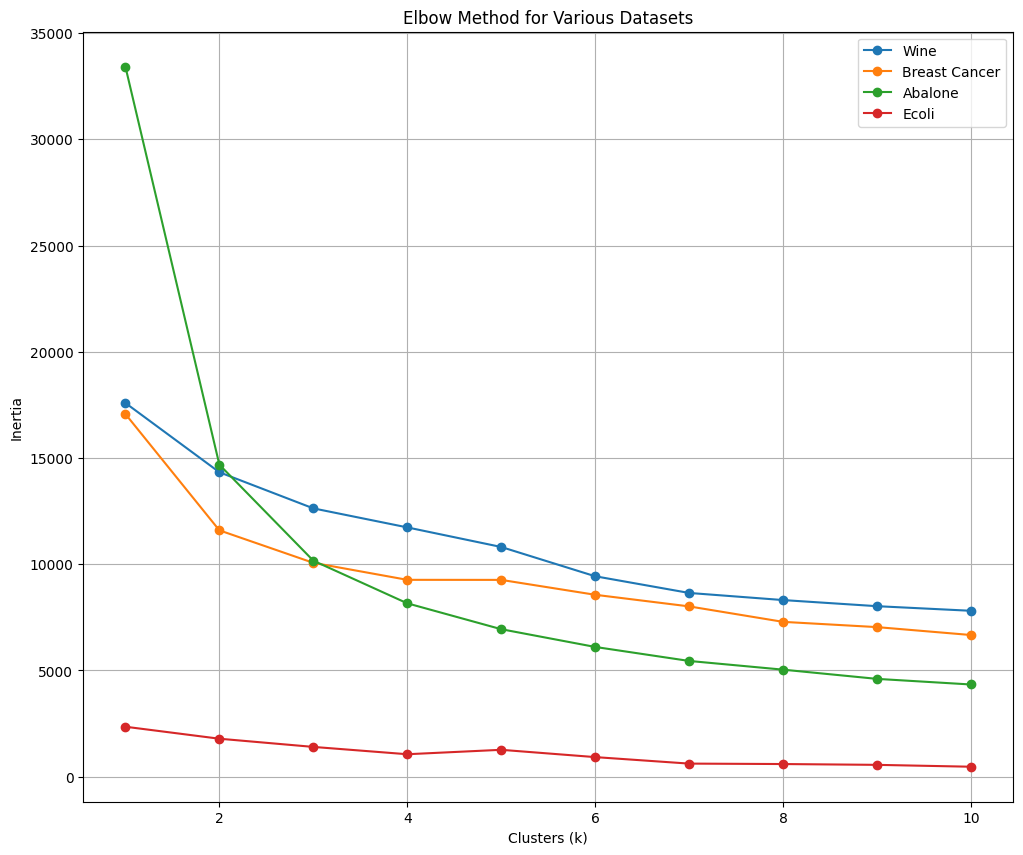

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler

def plot_elbow_method(data_dict, max_k):
    plt.figure(figsize=(12, 10))
    
    for name, data in data_dict.items():
        inercias = []
        k_range = range(1, max_k + 1)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(data)
            inercias.append(kmeans.inertia_)
        
        plt.plot(k_range, inercias, marker='o', label=name)
    
    plt.xlabel('Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Various Datasets')
    plt.legend()
    plt.grid(True)
    plt.show()


datasets = {
    'Wine': wine_data_scaled,
    'Breast Cancer': breast_cancer_data_scaled,
    'Abalone': abalone_data_scaled,
    'Ecoli': ecoli_data_scaled
}

plot_elbow_method(datasets, max_k=10)
